In [161]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Aggregating preferences: social choice

## 9.1 Introduction

Say you want to design a system to choose between a few different outcomes that impact people in different ways. Ideally you would simply add up the utility of each outcome across all people and then choose the best that way. The problem is there is a strong incentive to lie, and people also often can't put a number on something like that. One alternative is to ask about preferences instead (i.e., do you prefer A or B). The downside is you lose a huge amount of information, but it's easier and resistant to gamification. Of course, this is basically about voting systems. So how do they work, and what do they achieve?

You might think that a simple majority-vote system is the best, but consider this example here:

$$\begin{aligned}
\text{John:} & \quad a \succ b \succ c \\
\text{Brad:} & \quad b \succ c \succ a \\
\text{Anne:} & \quad c \succ b \succ a
\end{aligned}$$

Ideally you would have the system choose $b$ first. But note that a majority-vote system just results in a tie. If broken alphabetically this leads to option $a$ being chosen, the worst. An alternative rule follows something called the *Condorcet Condition*, which is that when one option $x$ is always preferred over every other option $y$ by at least half the people, then that option should be chosen. This rule would select $b$ as $b \succ a$ for 2 people, and $b \succ c$ for 2 people. While this seems like a nice solution, the actual preferences might not lead to a single profile which is always better than the others:

$$\begin{aligned}
\text{John:} & \quad a \succ b \succ c \\
\text{Brad:} & \quad b \succ c \succ a \\
\text{Anne:} & \quad c \succ a \succ b
\end{aligned}$$

In this case there is no profile which is a condorcet winner. All this is just to show that aggregating preferences is non-trivial!

## 9.2 A formal model

We have a set of outcomes $O$, a set of $N$ people, and for each person $i$ a ranking of their preferences $L_i$. 

A *social choice function* is a mapping from $L$ to $O$. 

A *social choice correspondence* is the same, but instead returns a set of outcomes. 

A *social welfare function* is a stronger version and maps $L$ to an order over the outcomes.

A *condorcet winner* is an outcome $o$ which has majority support over any other $o^\prime$. 

The *smith set* is the smallest set of outcomes where any outcome in the set is prefered by a majority to any outcome out of the set.

## 9.3 Voting

### 9.3.1 Voting methods

There are many different voting methods. 

*Plurality voting* is where everyone gets 1 vote.

*Cumulative voting* is where everyone gets $k$ votes, and can vote for the same canidate more than once.

*Approval voting* is where everyone can vote for any candidate, but not more than once.

*Plurality with elimination* is where everyone gets a single vote for one candidate and the candidates are eliminated from the least votes to the most, with losing votes being recast. 

*Borda voting* is where you submit a full ordering on all candidates and the number of votes a candidate gets is determined linearly by their position. Your favorite candidate gets $n$ votes, your least favorite gets $0$.

*Pairwise elimination* is where the candidates are compared against eachother one at a time with the least-prefered candidate getting eliminated. 

### 9.3.2 Voting paradoxes

These voting methods can each fail in different scenarios. Here is some code to run each of them:

In [186]:
def get_condorcet_winner(preferences):
    N,O = preferences.shape
    for option in range(O):
        option_rank = np.where(preferences==option)[1]
        success = True
        for alt in range(O):
            if option!=alt:
                alt_rank = np.where(preferences==alt)[1]
                if (alt_rank < option_rank).mean() >= 0.5: # if the alternative is better half the time, quit
                    success = False
                    break
        if success:
            return option
    return -1

def run_plurality_voting(preferences):
    N,O = preferences.shape
    best = -1
    best_score = 0
    for option in range(O):
        votes = np.sum(preferences[:,0]==option)
        if votes > best_score:
            best_score = votes
            best = option
    return best

def run_borda_voting(preferences):
    N,O = preferences.shape
    best = -1
    best_score = 0
    for option in range(O):
        ranks = np.where(preferences==option)[1]
        votes = np.sum(O-1-ranks)
        if votes > best_score:
            best_score = votes
            best = option
    return best

def run_pairwise_elimination(preferences):
    N,O = preferences.shape
    eliminated = np.zeros(O)
    while np.sum(eliminated)<O-1:
        choice1 = np.random.choice(np.arange(O)[eliminated==0])
        choice2 = np.random.choice(np.arange(O)[eliminated==0])
        if not choice1==choice2:
            choice1_rank = np.where(preferences==choice1)[1]
            choice2_rank = np.where(preferences==choice2)[1]
            if np.mean(choice1_rank < choice2_rank) > 0.5: # first is better for at least half
                eliminated[choice2]=1
    return np.argmin(eliminated)

Simple example from before...

In [187]:
example = np.array([
    [0,1,2],
    [1,2,0],
    [2,1,0],
])
 
print("condorcet winner:",get_condorcet_winner(example))
print("plurality winner:",run_plurality_voting(example))
print("borda winner:",run_borda_voting(example))
print("pairwise elimination winner",run_pairwise_elimination(example))

condorcet winner: 1
plurality winner: 0
borda winner: 1
pairwise elimination winner 1


For testing we need a way to make lots of perferences...

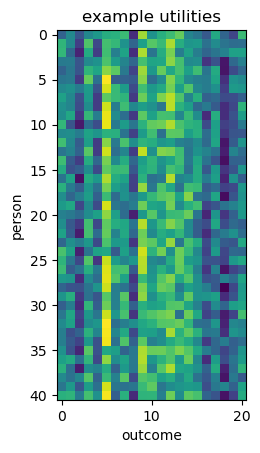

In [188]:
def make_random_preferences(N,O,iters=200):
    true_utilties = np.random.rand(N,O)
    for k in range(iters): # conversation simulation: everyone mixes their preference with someone else
        true_utilties = true_utilties * 0.99 + true_utilties[np.random.permutation(N)] * 0.01
    preferences = np.argsort(true_utilties,axis=1)[:,::-1]
    return true_utilties, preferences

utilities,preferences = make_random_preferences(41,21)
plt.imshow(utilities)
plt.title("example utilities")
plt.xlabel("outcome")
plt.ylabel("person")
plt.show()

And we can see how closely we match the condorcet winner (where there is one)

In [189]:
results = []
for t in range(500):
    utilities, preferences = make_random_preferences(41, 21)
    condorcet = get_condorcet_winner(preferences)
    plurality = run_plurality_voting(preferences)
    borda = run_borda_voting(preferences)
    pairwise = run_pairwise_elimination(preferences)
    results.append([condorcet, plurality, borda, pairwise])

df = pd.DataFrame(results, columns=["Condorcet", "Plurality", "Borda", "Pairwise Elimination"])

accuracy = {}
for col in ["Plurality", "Borda", "Pairwise Elimination"]:
    accuracy[col] = (df[col] == df["Condorcet"]).mean()

print("\nAverage accuracy of each method:")
for method, acc in accuracy.items():
    print(f"{method}: {acc:.2f}")


Average accuracy of each method:
Plurality: 0.86
Borda: 0.90
Pairwise Elimination: 0.97


## 9.4 Existence of social functions

### 9.4.1 Social welfare functions

One interesting result is that there is no social welfare function over at least 3 outcomes which meets these three criteria at the same time in every scenraio:

1. **Pareto efficiency** - If everyone prefers $a$ over $b$, then the function must rank $a$ higher than $b$.
2. **Irrelevance of alternative options** - The ranking of $a$ vs $b$ should only depend on the preferences for $a$ and $b$, not alternatives.
3. **Non-dictatorship** - There should be no single person who completely determines the ordering of all outcomes.

I.e., for *any* algorithm there is always a set of preferences which breaks these conditions. To prove this we need the notion of a weakly decisive coalition, which is one which has the power, under the social welfare function, to decide the ranking of two particular outcomes, $a$ and $b$, regardless of everyone elses' preferences. We also need a decisive coalition, which is one which has the power to determine the ranking between any two outcomes for a particular set of other preferences, and social choice function. For instance, say we have:

$$\begin{aligned}
\text{John:} & \quad ? \succ ? \succ ? \\
\text{Brad:} & \quad ? \succ ? \succ ? \\
\text{Anne:} & \quad c \succ b \succ a
\end{aligned}$$

and use a majority-rule system. John and Brad form a decisive coalition in that they have the power to determine the full ordering on their own. This is just one example for a particular social choice function. 

Note that *all* social choice functions have at least one decisive coalition, because the *whole* group is itself decisive. If everyone ranks the outcomes $a \succ b \succ c$ then regardless of what social choice function $W$ you use you still need $a \succ_W b \succ_W c$, by pareto efficiency. Therefore the whole group is a decisive coalition. 

Now we show that if a coalition is weakly decisive there is also a set of preferences where it is fully decisive. Say a coalition is weakly decisive over $a$ and $b$. Imagine that other members outside the coalition rank $c \succ a$ and $b \succ c$. If the coalition votes $a \succ b \succ c$ by pareto efficiency we need $b \succ_W c$ and by the weakly decisive condition we also need $a \succ_W b$ which implies $a \succ_W c$, against the preferences of all of the outside group. Therefore the coalition is decisive over $c$ too, etc.

Now the next stage is to show there is always a set of preferences where a decisive coalition breaks down into further decisive coalitions.

Imagine a coalition $G$ which is decisive. Say the preferences split like this:

$$\begin{aligned}
\text{G1:} & \quad x \succ y \succ z \\
\text{G2:} & \quad z \succ x \succ y \\
\text{Others:} & \quad y \succ z \succ x
\end{aligned}$$

Note that because the full coalition $G$ has $x \succ y$ it means that the final ordering is restricted to $x \succ y \succ z$ or $x \succ z \succ y$ or $z \succ x \succ y$. The first two have $x \succ z$ and the second two have $z \succ y$ which means one or the other or both have to be true. If $x \succ z$ it means $G1$ is weakly decisive over the ranking of $x$ and $z$ because everyone else voted the other way and it still happened. If $z \succ y$ it means $G2$ is weakly decisive over the ranking of $y$ and $z$ because everyone else voted the other way and it and it still happened. Now from before being weakly decisive over two variables makes you decisive over all others. 

The group of all players is decisive, and following this splitting method you can get to a single person determining all outcomes. I.e., a dictator.

### 9.4.2 Social choice functions

Social choice is just about selecting the *best* outcome, so it might be easier than the above. We can define a similar 3 measures:

1. **Weak pareto efficiency** - The function should not select $o_2$ if a majority prefer $o_1$.
2. **Monotonicity** - If the outcome $o$ is the winner it should stay the winner if it gets increased support.
3. **Nondictatorship** - The function should not be such that it always selects the top choice for some agent $j$.

Unfortunately, a similar proof holds that meeting all 3 of these criteria is impossible.

## 9.5 Ranking systems

While this is a bit depressing we can make slight headway if we impose a couple of restrictions. Firstly, we can say that the outcomes are just the agents themselves. This could be in the context of a collective decision (picking a leader), or maybe webpages ranking eachother. Secondly, we say that each agent just has a set of people they like, and a set they don't like. Within each set they are indifferent. A ranking rule in this context is a social welfare function which asigns a rank to everyone. 

What this really amounts to is a restriction of the outcomes for each agent. Basically you either get someone you want in charge or you don't. This gets around the "at least 3 outcomes" bit before. One algorithm which satisfies the 3 above conditions is approval voting. The candidate which appears in the greatest number of 'yes' pools is then selected. This also turns out to be the only algorithm which works.

One of the things we might want a ranking function to achieve is transitivity. If A votes for B, C votes for D, but D votes for E, it is sensible that E wins. Unfortunately there is no ranking system which achieves this without violating the the irrelevant alternatives condition.

We can simplify things a bit by dropping the strict conditions. We can define ranked independence of irrelevant alternatives (RIIA) for a ranking rule as being when it assigns relevant ranks in a consistent manner using only the number of votes for each outcome and the relative ranks of the voters. We can also define a separate transitivity condition called strong quasi-transitivity. There are ranking algorithms which satisfy both these conditions, e.g.,

In [213]:
prefered = [
    [1,2,3,4],
    [3],
    [1,3],
    [4,5],
    [4,5],
    [5]
]
N = len(prefered)
rank = np.zeros(N)
for epoch in range(100):
    for n in range(N):
        voters_for = np.array([i for i in range(N) if n in prefered[i]])
        if len(voters_for)>0:
            rank[n] = (len(voters_for) + np.max(rank[voters_for])) / (N+1)
        else:
            rank[n] = 0

print("order:",np.argsort(rank))

order: [0 2 1 3 4 5]


0 came last as they got no votes.  <br>
2 came 5th as they just got 1 vote. <br>
1 came 4th as they got 2 votes. <br>
3, 4, and 5 all had 3 votes, but 3 voted for 4, and 3 and 4 both voted for 5. <br>